In [1]:
!pip install torchstain

In [2]:

import os
import cv2
import time
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from sklearn import metrics as mc
# import torchstain

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt

DIR_TRAIN = "/kaggle/input/crc-tissue-phenotyping-crc-tp-dataset/Fold1/"
DIR_TEST = "/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-HE-100K-NONORM/"


In [3]:
import torchstain
normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
target = cv2.imread('/kaggle/input/crc-tissue-phenotyping-crc-tp-dataset/Fold1/Training/Tumor/1000.png')
target = cv2.resize(target, (128, 128))
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
target = np.transpose(target, (2, 0, 1))
target= torch.tensor(target)
normalizer.fit(target)

In [4]:
def get_instance_count():
    ## Displaying instance Count for each class
    path = os.path.join(DIR_TRAIN, 'Training')
    
    print("Instances Count: ")
    for file in os.listdir(path):
        print(file, len(os.listdir(os.path.join(path, file))))
    print('\n\n')


def get_df_and_class_mapping(path):
    labels_mapping = dict()
    file_path = []
    class_label = []
    
    for index,classname in enumerate(os.listdir(path)): 
        labels_mapping[classname] = index
        for filename in os.listdir(os.path.join(path, classname)):
            file_path.append(os.path.join(path, classname, filename))
            class_label.append(index)
    
    file = {"img": file_path, "class": class_label}
    df = pd.DataFrame(file)
    
    return df, labels_mapping
    

def get_test_df_and_class_mapping(path):
    labels = {'STR': 'Stroma', 'TUM': 'Tumor', 'MUS': 'Muscle', 'DEB': 'Debris', 'NORM': 'Benign', 'LYM': 'Inflammatory'}
    mapping = {'Complex Stroma': 0,
         'Stroma': 1,
         'Tumor': 2,
         'Inflammatory': 3,
         'Benign': 4,
         'Muscle': 5,
         'Debris': 6}
    
    labels_mapping = dict()
    file_path = []
    class_label = []
    
       
    
    for _,classname in enumerate(os.listdir(path)): 
        if not classname in labels.keys():
            continue
            
        index = mapping[labels[classname]]
        labels_mapping[labels[classname]] = index
        for filename in os.listdir(os.path.join(path, classname)):
            file_path.append(os.path.join(path, classname, filename))
            class_label.append(index)
    
    file = {"img": file_path, "class": class_label}
    df = pd.DataFrame(file)
    
    return df, labels_mapping


    
    
        
        
    
    
    
    
    
        


In [5]:
## Formulating Datasets and label mapping
get_instance_count()

path = os.path.join(DIR_TRAIN, 'Training')
train_df, train_labels_mapping = get_df_and_class_mapping(path)

path = os.path.join(DIR_TRAIN, 'Testing')
valid_df , valid_labels_mapping = get_df_and_class_mapping(path)

path = DIR_TEST
test_df , test_labels_mapping = get_test_df_and_class_mapping(path)


    
    

Instances Count: 
Complex Stroma 35000
Stroma 35000
Tumor 35000
Inflammatory 21000
Benign 21000
Muscle 35000
Debris 14000





In [6]:
train_df = train_df[train_df['class']!=0].reset_index(drop=True)
valid_df = valid_df[valid_df['class']!=0].reset_index(drop=True)

In [7]:
train_df.sample(5)

,img,class
12522,/kaggle/input/crc-tissue-phenotyping-crc-tp-da...,1
108342,/kaggle/input/crc-tissue-phenotyping-crc-tp-da...,4
35854,/kaggle/input/crc-tissue-phenotyping-crc-tp-da...,2
59208,/kaggle/input/crc-tissue-phenotyping-crc-tp-da...,2
42320,/kaggle/input/crc-tissue-phenotyping-crc-tp-da...,2


In [8]:
test_df.sample(10)

,img,class
52706,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,3
42906,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,4
16937,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,6
47703,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,4
53271,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,3
66851,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,1
46088,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,4
60043,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,1
45715,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,4
27420,/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-H...,5


In [9]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transform_train():
    return A.Compose([
       
        A.Resize(150, 150 ),
        A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.08, rotate_limit=15, p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        ToTensorV2(),
        
    ])

def get_transform_valid():
    return A.Compose([
       
        A.Resize(150, 150),
        ToTensorV2(),
        
    ])

class BCIDataset(Dataset):
    
    def __init__(self, base_path, images, labels, transforms = None):
        
        super().__init__()
        self.base_path = base_path
        self.images = images
        self.labels = labels
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.base_path + self.images[index]
        
        #Reading image
        image = cv2.imread(image_path,1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        
        
        
        
        if self.transforms:
            image= self.transforms(image=image)["image"]
        
        try:
            image, H, E = normalizer.normalize(I=image, stains=True)
            image = torch.tensor(np.transpose(image, (2, 0, 1)))
        except:
            pass

        
        
        image = image.float()
        image = image / 255.0
        label = self.labels[index] - 1
        label = torch.tensor(label)
        
        #Applying transforms on image
        
        
        return image, label
        
        
        
    def __len__(self):
        return len(self.images)


In [10]:
train_dataset = BCIDataset("",train_df["img"].to_list(), train_df["class"].to_list(), get_transform_train())
valid_dataset = BCIDataset("",valid_df["img"].to_list(), valid_df["class"].to_list(), get_transform_valid())


train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 512,
    shuffle= True,
    num_workers = 4,
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 512,
    shuffle=False,
    num_workers = 4,
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# for images, labels in train_data_loader:
#     print(labels)
#     fig, ax = plt.subplots(figsize = (10, 10))
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.imshow(make_grid(images, 4).permute(1,2,0))
#     break

In [12]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e94dcdacc791c287fc5618ecf368685818e00c4efef0cd52815ec0453bed1b26
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
Successfully built efficientnet_pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [14]:

torch.cuda.empty_cache()
softmax = torch.nn.functional.softmax

# model.load_state_dict(torch.load("./model.pth"))
# model.to(device)
model = torch.nn.DataParallel(model)
model = model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss().to(device)

In [15]:
LOG_FILE = open("./file.txt", "w")

def write_in_log_file(values):
    LOG_FILE = open("./file.txt", "a")
    for key in values:
        LOG_FILE.writelines(key+ ': '+ str(values[key]) + '\n')

epoch:  0
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 0 ** - Epoch Time 1838
Train Loss = 0.654
Train F1 Score = 0.7541737907168858 % 

Val Loss = 0.5582
Val F1_Score = 0.7836899570703482 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


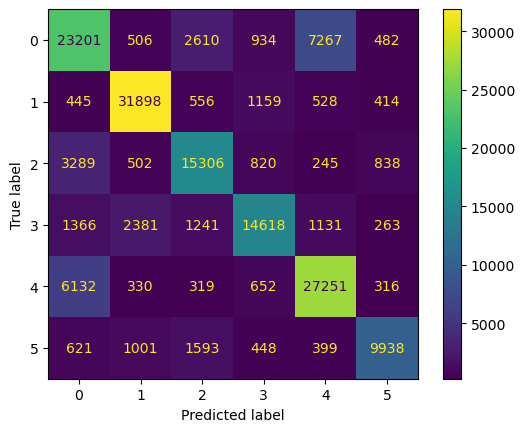

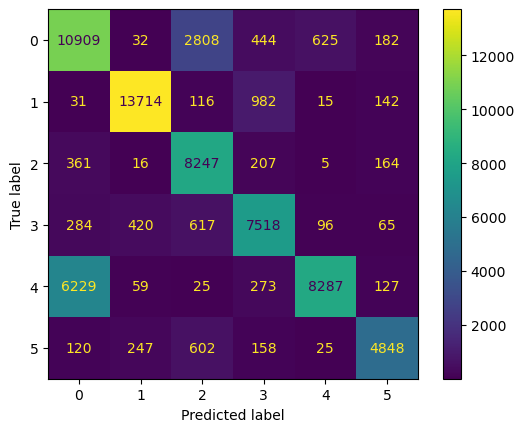

epoch:  1
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 1 ** - Epoch Time 1597
Train Loss = 0.4059
Train F1 Score = 0.8439914329537596 % 

Val Loss = 0.3489
Val F1_Score = 0.8658700168532452 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


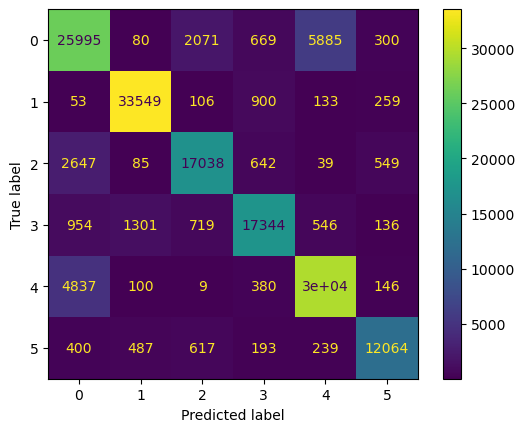

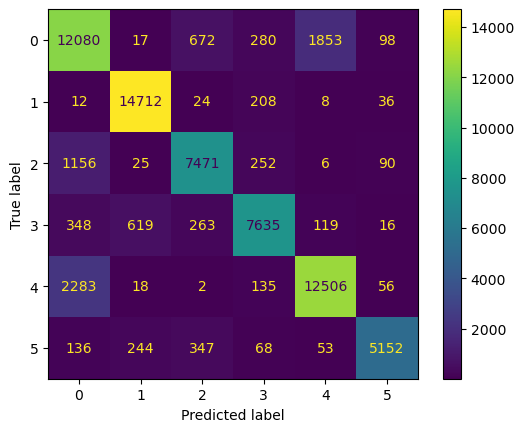

epoch:  2
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 2 ** - Epoch Time 1562
Train Loss = 0.3662
Train F1 Score = 0.8589182096627335 % 

Val Loss = 0.3266
Val F1_Score = 0.8742034410047853 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


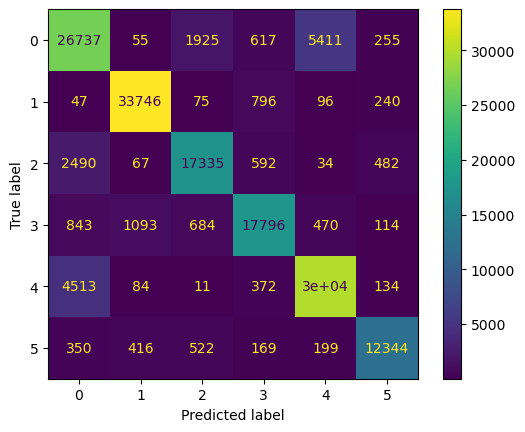

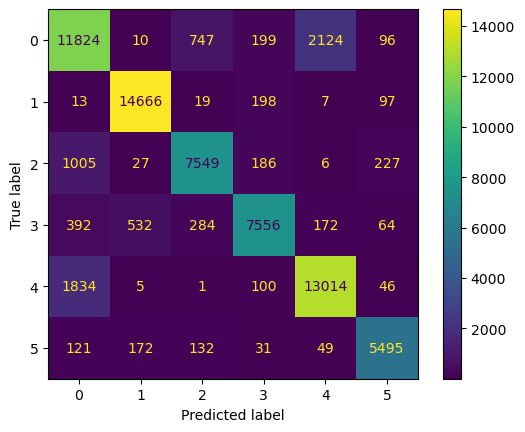

epoch:  3
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 3 ** - Epoch Time 1597
Train Loss = 0.3418
Train F1 Score = 0.8681617292247767 % 

Val Loss = 0.3161
Val F1_Score = 0.8795298679555642 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


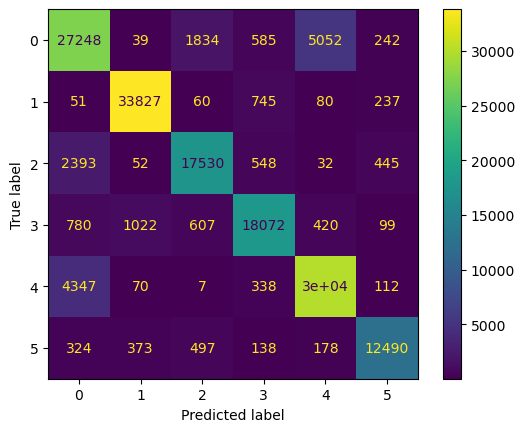

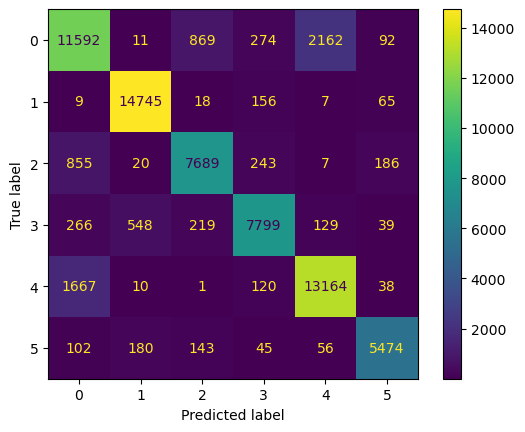

epoch:  4
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 4 ** - Epoch Time 1639
Train Loss = 0.3235
Train F1 Score = 0.8752212273061907 % 

Val Loss = 0.3151
Val F1_Score = 0.8802159492263283 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


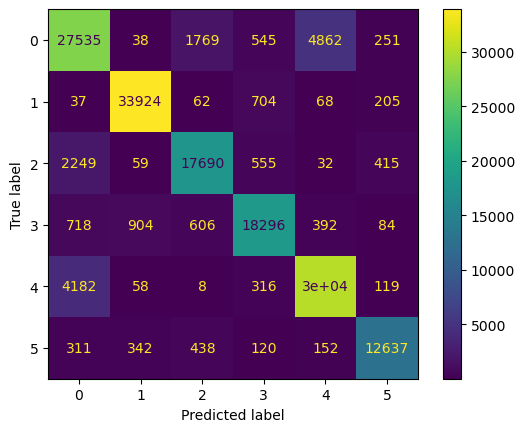

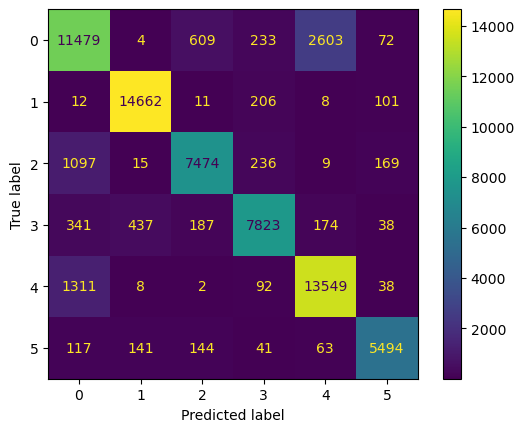

epoch:  5
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 5 ** - Epoch Time 1603
Train Loss = 0.3053
Train F1 Score = 0.8834741232264706 % 

Val Loss = 0.3076
Val F1_Score = 0.8827766150487042 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


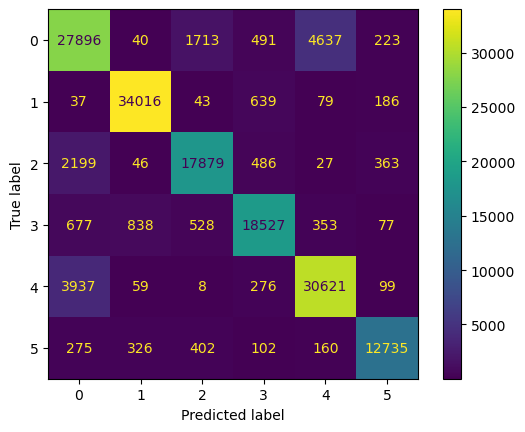

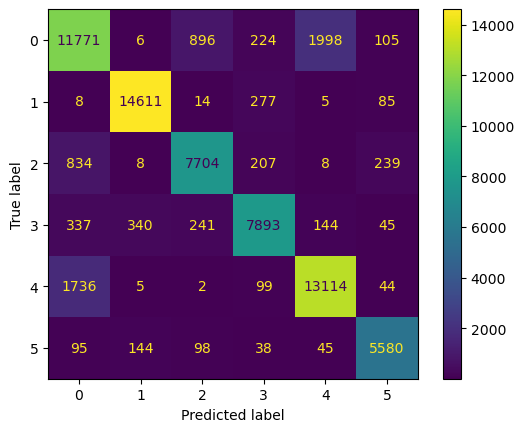

epoch:  6
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 6 ** - Epoch Time 1652
Train Loss = 0.291
Train F1 Score = 0.8892674292633885 % 

Val Loss = 0.3087
Val F1_Score = 0.8829153658281216 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


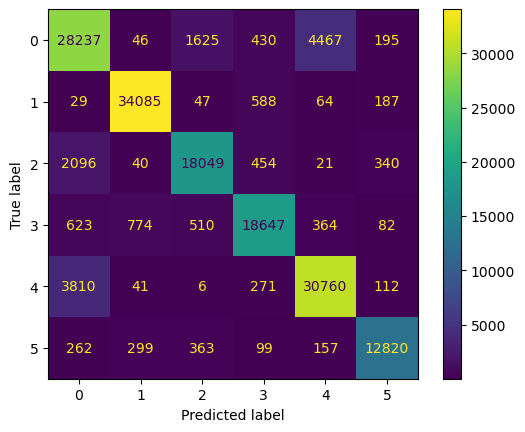

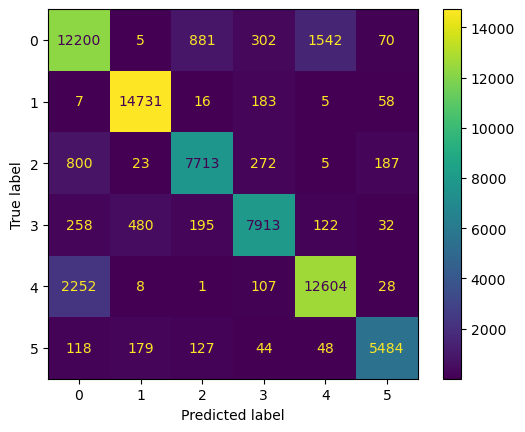

epoch:  7
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 7 ** - Epoch Time 1622
Train Loss = 0.2773
Train F1 Score = 0.8939416783482522 % 

Val Loss = 0.3087
Val F1_Score = 0.8842810804029534 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


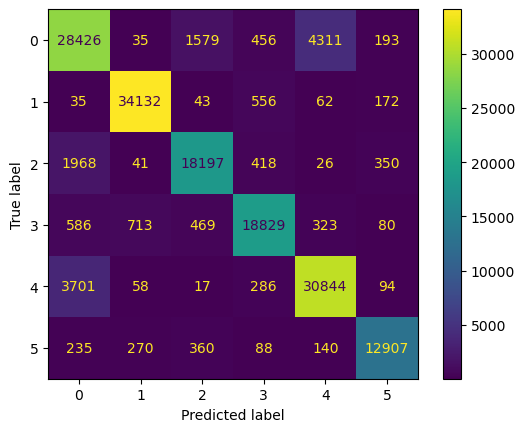

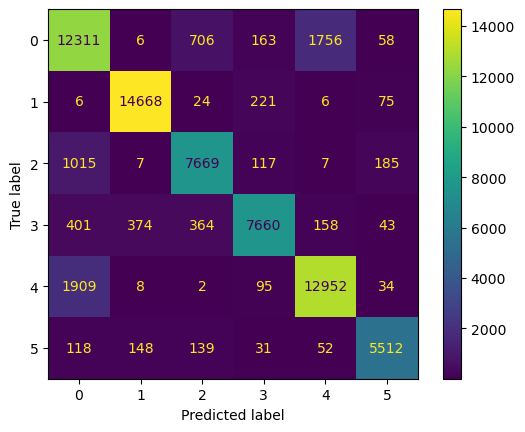

epoch:  8
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 8 ** - Epoch Time 1662
Train Loss = 0.2628
Train F1 Score = 0.9012290488366883 % 

Val Loss = 0.3122
Val F1_Score = 0.8849472800481912 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


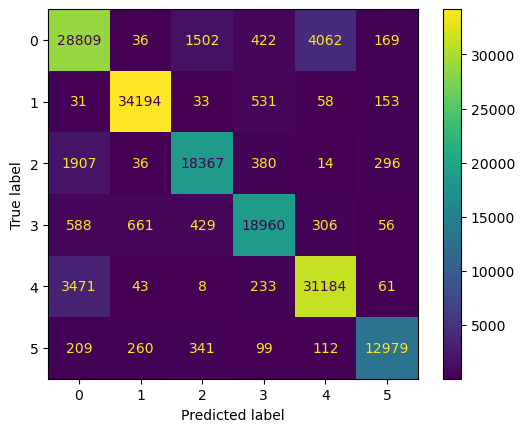

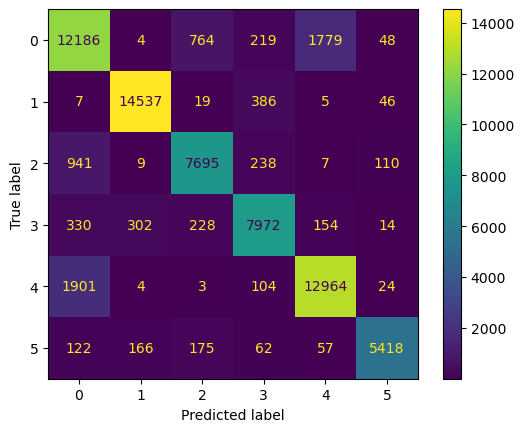

epoch:  9
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 9 ** - Epoch Time 1625
Train Loss = 0.249
Train F1 Score = 0.9058682343008275 % 

Val Loss = 0.3209
Val F1_Score = 0.8842788065863957 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


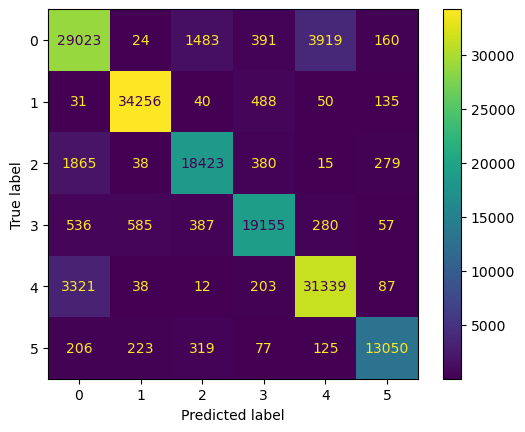

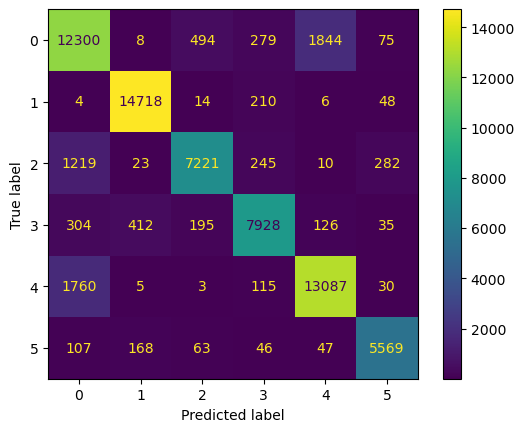

epoch:  10
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 10 ** - Epoch Time 1589
Train Loss = 0.2363
Train F1 Score = 0.911507400461784 % 

Val Loss = 0.3222
Val F1_Score = 0.8838138063667373 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


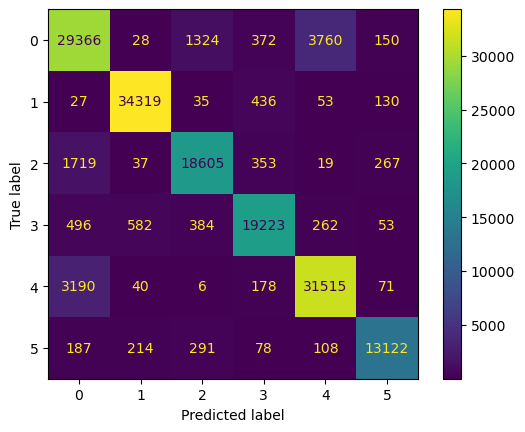

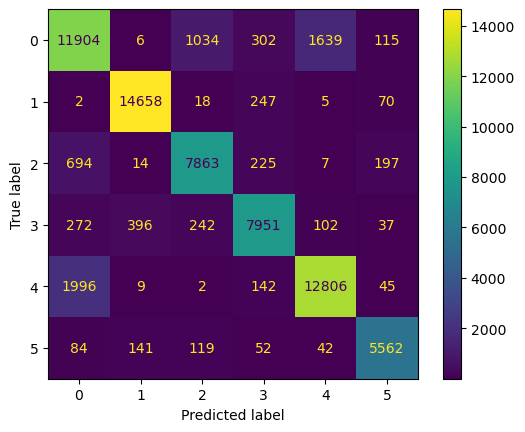

epoch:  11
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 11 ** - Epoch Time 1577
Train Loss = 0.2276
Train F1 Score = 0.9146325705809962 % 

Val Loss = 0.3292
Val F1_Score = 0.8842241497178968 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


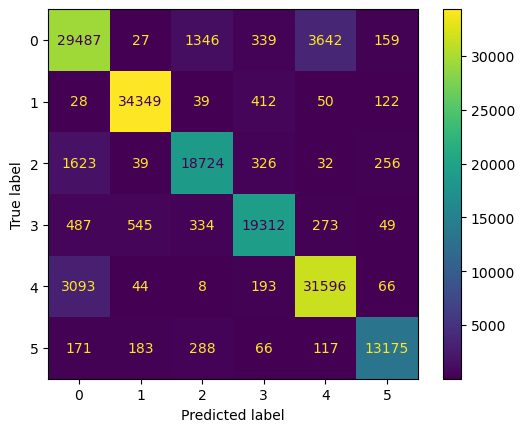

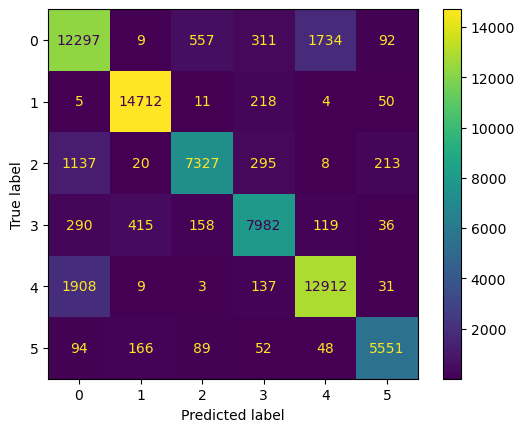

epoch:  12
Training


  0%|          | 0/315 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Validation


  0%|          | 0/135 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

** Epoch 12 ** - Epoch Time 1564
Train Loss = 0.2143
Train F1 Score = 0.9203045436624558 % 

Val Loss = 0.3358
Val F1_Score = 0.8831730782626789 % 

(161000,)
(161000,)
Train Confusion Matrix: 
Valid Confusion Matrix: 


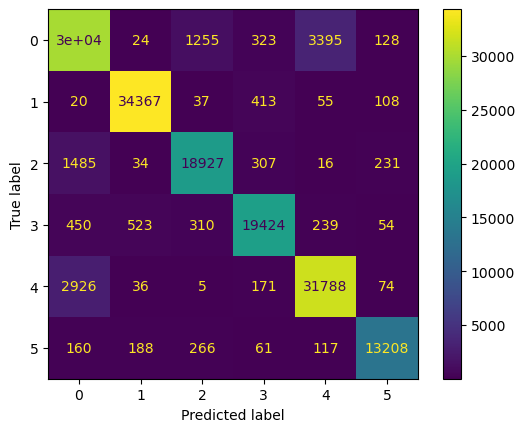

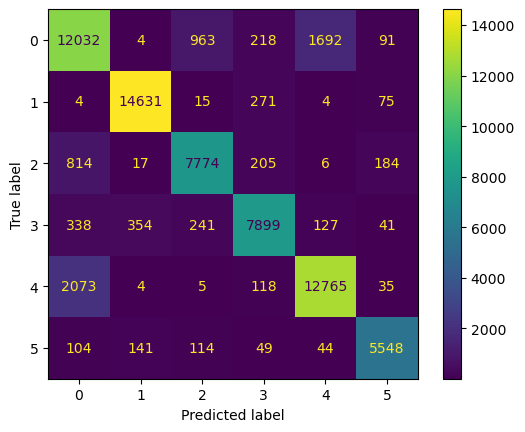

In [16]:
### Training Code
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

for epoch in range(13):
    
    print("epoch: ", epoch)
    
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_labels =[]
    train_preds = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    valid_labels = []
    valid_preds = []
    
    # Training
    model.train()
    print("Training")
    for images, labels in tqdm(train_data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        preds1 = torch.argmax(softmax(preds.clone(), dim=1), dim=1)
        
        #Calculate Accuracy
        train_labels +=labels.detach().cpu().numpy().tolist()
        train_preds+=preds1.detach().cpu().numpy().tolist()
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        
    
    ### Printing Training Stats
    epoch_loss = np.mean(train_epoch_loss)
    precision, recall, f1_score, _ = precision_recall_fscore_support(train_labels, train_preds, average='macro')

    logs = dict()
    logs['Epoch'] = epoch
    logs['Epoch Loss'] = epoch_loss
    logs['Precision_Recall_F1'] = [precision, recall, f1_score]


    #Validation
    model.eval()
    with torch.no_grad():
        print("Validation")
        for images, labels in tqdm(valid_data_loader):
        
            images = images.to(device)
            labels = labels.to(device)
        
            #Forward ->
            preds = model(images)
            preds1 = torch.argmax(softmax(preds.clone(), dim=1), dim=1)
        
            #Calculate Accuracy
            valid_labels += labels.detach().cpu().numpy().tolist()
            valid_preds += preds1.detach().cpu().numpy().tolist()
            

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            val_epoch_loss.append(loss_value)
    
    
    
    val_epoch_loss = np.mean(val_epoch_loss)
    valid_precision, valid_recall, valid_f1_score, _ = precision_recall_fscore_support(valid_labels, valid_preds, average='macro')
    logs['Valid Epoch Loss'] = val_epoch_loss
    logs['Valid Precision_Recall_F1'] = [valid_precision, valid_recall, valid_f1_score]

    end = time.time()
    

    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(epoch_loss, 4)))
    print("Train F1 Score = {} % \n".format(f1_score))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val F1_Score = {} % \n".format(valid_f1_score))
    
    if valid_f1_score >= 0.60:
        torch.save(model.state_dict(), "./model_"+str(round(f1_score,4))+"__"+str(round(valid_f1_score, 4))+".pth")
        
    print(np.array(train_labels).shape)
    print(np.array(train_preds).shape)
    
    train_cf = mc.confusion_matrix(train_labels, train_preds)
    valid_cf = mc.confusion_matrix(valid_labels, valid_preds)

    logs["Train Confusion Matrix"] = train_cf
    logs["Valid Confusion Matrix"] = valid_cf
    write_in_log_file(logs)
    
    print("Train Confusion Matrix: ",)
    pt = mc.ConfusionMatrixDisplay(confusion_matrix=train_cf, display_labels=[0,1,2,3,4,5])
    pt.plot()
    print("Valid Confusion Matrix: ",)
    pt = mc.ConfusionMatrixDisplay(confusion_matrix=valid_cf, display_labels=[0,1,2,3,4,5])
    pt.plot()
    
    plt.show()
    
    
    